# Modal analysis of a 2D-beam

Notebook to introduce Modal analysis in FEniCS.

What will be shown here is a 2D-beam clamped on the left hand side. 

In [1]:
from petsc4py import PETSc
from slepc4py import SLEPc
from dolfin import *
% matplotlib inline
import mshr
from MA_tools import get_interior_index_set, reduce_matrix, extract_modes
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

The beam is modeled by a rectangular domain that is meshed using <code>mshr</code>. The left hand side and right hand side of the domain are defined to apply the clamped boundary condition and loading.

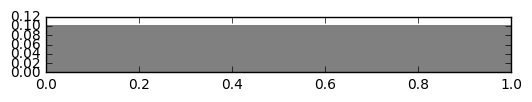

In [2]:
# Create mesh
height = 0.1
length = 1.000

P0 = Point(0., 0.)
P1 = Point(length, height)
domain = mshr.Rectangle(P0, P1)

dens = 300
mesh = mshr.generate_mesh(domain, dens)

# Mark boundary subdomains
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0.))
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], length))

# set boundary markers
#boundary_markers = FacetFunction('size_t', mesh)
left = BoundaryLeft()
right = BoundaryRight()
#left.mark(boundary_markers, 0)
#right.mark(boundary_markers, 1)
#ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)


plt.figure()
plot(mesh)
plt.show()

The material properties of steel are used in this example. Hooke's law is used for linear elasticity.

In [3]:
# Mass density
rho = 7.8e4

# Elasticity parameters
E, nu = 2.1e9, 0.3

# Lamé constants 
mu    = Constant(E / (2.0*(1.0 + nu)))
lmbda = Constant(E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))

# Define strain and stress
# Using the plane stress hypothesis
def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u):
    return 2*mu*sym(grad(u)) + lmbda*tr(sym(grad(u)))*Identity(len(u))

## Geometric stiffness ##

The Geometric stiffness is derived by  by energy derivation:

$$
\Pi(u) = \int_{\Omega_0} \mathcal{W}(\mathcal{F}) \text{d}V_0 - \Pi_{ext}(u) \\
D_{v}\Pi(u) = \Pi'(u)(v) = \int_{\Omega_0} \left< \frac{\text{d}\mathcal{W}(\mathcal{F})}{\text{d}\mathcal{F}}, \nabla v \right> \text{d}V_0 - D_{v}\Pi_{ext}(u) \\
D_{\Delta u}\Pi'(u, v) = \Pi''(u, v, \hat{u}) = \int_{\Omega_0} \nabla v \frac{\text{d}^2\mathcal{W}(\mathcal{F})^2 }{\text{d}\mathcal{F}^2} \cdot \nabla \hat{u}  \text{d}V_0 \\
\Pi''(u, v, \hat{u}) = \int_{\Omega_0} \nabla v \mathcal{T} \cdot \nabla \hat{u}  \text{d}V_0 + \int_{\Omega_0} \mathbb{C}_{\mathcal{E}} \left[\mathtt{DE}(\hat{u})\right] \cdot \mathtt{DE}(v)  \text{d}V_0
$$

We are looking at a linear elastic problem, so that Hooke's law becomes:
$$\sigma(u) = 2 \mu \epsilon(u) + \lambda \cdot \mathrm{tr} (\epsilon(u)) \delta \\
\mathtt{DE}(u) = \epsilon(u) =  sym \nabla(u) $$
With $\lambda$ and $\mu$ are Lamé constants.

By linearizing the nonlinear stress tensors we can derive the geometric stiffness and tangential stiffness bilinear forms:
$$
a_{geom}(u, v) = P <\nabla v_x, \nabla u_x>  \\
a_{el}(u, v) = <\sigma(u), \epsilon(v)> 
$$

In [4]:
# Create function space
V = VectorFunctionSpace(mesh, "Lagrange", 1)

# Create test and trial functions, and source term
u = TrialFunction(V)
v = TestFunction(V)

# Applied force
P_applied = -1.

# Define boundary conditions
bc = DirichletBC(V, Constant((0.0, 0.0)), left)

# Define bilinear forms of the elastic tangent and geometric stiffness components
a_el = inner(sigma(u), epsilon(v))*dx 
a_geom = P_applied*inner(grad(v[0]),grad(u[0]))*dx

To assemble the matrices: we assemble the geometric stiffness and tangential stiffness matrices seperately and then add them up to the total stiffness matrix so that:

$$
\mathbf{K} = \mathbf{K}_{\sigma} + \mathbf{K}_0
$$
With
+ $\mathbf{K}_{\sigma}$ is the geometric stiffness matrix
+ $\mathbf{K}_{0}$ is the elastic stiffness matrix

In [5]:
# Assemble matrices
K_el = PETScMatrix()
K_geom = PETScMatrix()
M_mat = PETScMatrix()
F_vec = PETScVector()

Le = dot(Constant((1., 1.)), v)*ds # Dummy linear variational form

assemble_system(a_el, Le, bc, A_tensor=K_el, b_tensor=F_vec)
assemble_system(a_geom, Le, bc, A_tensor=K_geom, b_tensor=F_vec)
assemble_system(rho*dot(u,v)*dx, Le, bc, A_tensor=M_mat, b_tensor=F_vec)

# Define total stiffness matrix
K_total = PETScMatrix(K_el.mat() + K_geom.mat())

# So now we have a symmetric stiffness matrix, check how symmetric it is:
print(K_total.is_symmetric(1e-5))
print(K_total.is_symmetric(1e-6))

True
False


Functions to compute the modes that are used to reduce the domain of the matrices to take the interior domain, thus excluding Dirichlet boundary conditions. Furthermore there is a function to project vectors from the reduced domain back to the full domain.

Extract modes from the reduced domain by solving the generalized eigenvalue problem. 

In [6]:
# x = SpatialCoordinate(V)
Inertia = length*height**3 / 12.  # assemble(x[1]*(x[1] - height/2)*dx)

I = Inertia
K = 2.        # One side clamped the other side free
L = 1.

F_crit =  (np.pi**2)*E*I / ((K*L)**2)
F_crit2 =  (np.pi**2)*E*height / (3.*(K)**2)
print("Theoretical buckling load: ", F_crit)
P_crit = F_crit/height
print("Critical pressure", P_crit)

('Theoretical buckling load: ', 431795.1925476595)
('Critical pressure', 4317951.925476595)


In [7]:
def setup_problem(dens):
    mesh = mshr.generate_mesh(domain, dens)

    # Create function space
    V = VectorFunctionSpace(mesh, "Lagrange", 1)

    # Create test and trial functions, and source term
    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Define boundary conditions
    bc = DirichletBC(V, Constant((0.0, 0.0)), left)
    
    # Applied force
    P_applied = -1.

    # Define bilinear forms of the elastic tangent and geometric stiffness components
    a_el = inner(sigma(u), epsilon(v))*dx 
    a_geom = P_applied*inner(grad(v[0]),grad(u[0]))*dx
    
    # Assemble matrices
    K_el = PETScMatrix()
    K_geom = PETScMatrix()
    M_mat = PETScMatrix()
    F_vec = PETScVector()

    Le = dot(Constant((0., 0.)), v)*dx # Dummy linear variational form

    assemble_system(a_el, Le, bc, A_tensor=K_el, b_tensor=F_vec)
    assemble_system(a_geom, Le, bc, A_tensor=K_geom, b_tensor=F_vec)
    assemble_system(rho*dot(u,v)*dx, Le, bc, A_tensor=M_mat, b_tensor=F_vec)
    return M_mat, K_el, K_geom, bc, V

In [8]:
# A number of eigenvalues are calculated for each load and mesh density
neigs = 3
P_list = np.linspace(0., 1.2*P_crit, 50)
D_list = np.linspace(50,100, 3, dtype=int)

evlist = np.zeros((len(D_list), len(P_list), neigs), dtype='complex')
modelist = []

for d_idx in range(len(D_list)):
    print "dens = ", D_list[d_idx]
    M_mat, K_el, K_geom, bc, V = setup_problem(D_list[d_idx])
    for p_idx in range(len(P_list)):
        K_total = PETScMatrix(K_el.mat() + (P_list[p_idx]+DOLFIN_EPS_LARGE) * K_geom.mat())
        modes, evs = extract_modes(K_total, M_mat, V, bc, neigs)
        evlist[d_idx, p_idx] = evs[:neigs]
modelist.append(modes)

dens =  50
dens =  75
dens =  100


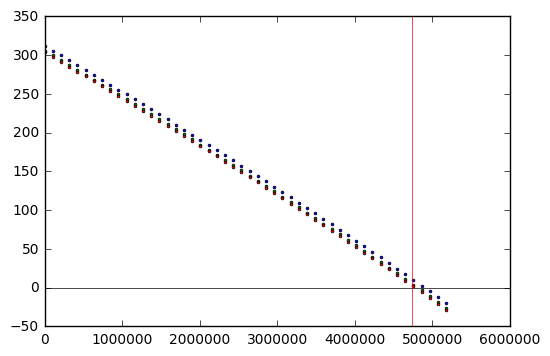

In [9]:
plt.figure()
plt.axhline(0., color='k', lw = 0.5)
for d_idx in range(len(D_list)):
    plt.plot(P_list, evlist[d_idx, :, :1].real, 'o', ms=2)
plt.axvline(P_crit/(1-.3**2), linewidth=0.5, color='r')
plt.ylabel
plt.show()

/usr/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


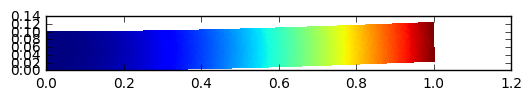

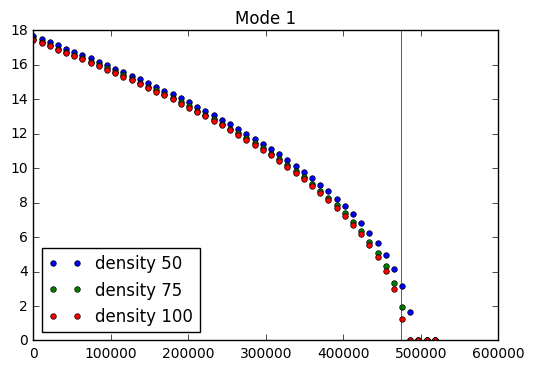

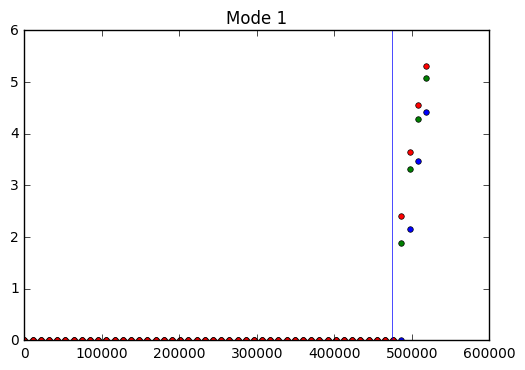

In [10]:
# Since force = pressure * surface
F_list = P_list*height

plt.figure()
plot(modelist[0][0], mode='displacement')

plt.figure()
plt.title("Mode 1")
plt.axhline(0., color='k', lw = 0.5)
for d_idx in range(len(D_list)):
    plt.plot(F_list, evlist[d_idx, :, 0]**0.5.real, 'o', ms=4., label="density {}".format(str(D_list[d_idx])))
plt.axvline(F_crit/(1-.3**2), lw=0.5)
plt.legend(loc="best")
plt.show()

plt.figure()
plt.title("Mode 1")
plt.axhline(0., color='k', lw = 0.5)
#plt.plot(F_list, evlist[:, 0]**0.5.real, 'o', ms=4., label="Frequency")
for d_idx in range(len(D_list)):
    plt.plot(F_list, (-evlist[d_idx, :, 0])**0.5.real, 'o', ms=4., label="density {}".format(str(D_list[d_idx])))
plt.axvline(F_crit/(1-.3**2), lw=0.5)
plt.show()

#plt.figure()
#plot(modelist[-1][0], mode='displacement')

# Construct Jacobian matrix

$$
\mathbf{M}\dot{y} + \mathbf{K}x = \mathbf{F} \\
\mathbf{A}\dot{x} - \mathbf{A}y = 0
$$
Where $\mathbf{A}$ can be chosen freely.

Rewriting in matrix form:
$$
\begin{bmatrix}
0 & \mathbf{I} \\
\mathbf{A} & 0
\end{bmatrix}  \begin{pmatrix} \dot{x} \\
\dot{y}  \end{pmatrix} = \begin{bmatrix} -\mathbf{M}^{-1}\mathbf{K} & \mathbf{0} \\
\mathbf{0} & \mathbf{A}
\end{bmatrix} 
\begin{pmatrix} x \\ y \end{pmatrix}
+ \begin{pmatrix} \mathbf{M}^{-1}\mathbf{F} \\
\mathbf{0} \end{pmatrix}
$$


$$
\mathbf{J} = \begin{bmatrix}
-\mathbf{M}^{-1}\mathbf{K} & \mathbf{0}   \\
\mathbf{0} & \mathbf{A}
\end{bmatrix}
$$

Or to avoid the inversion of $\mathbf{M}$, we keep $\mathbf{M}$ on the left hand side and we choose $\mathbf{A}=\mathbf{M}$ to make the left hand side symmetric:
$$
\begin{bmatrix}\mathbf{0} & \mathbf{M} \\
\mathbf{M} & \mathbf{0}
\end{bmatrix}
\begin{pmatrix} \dot{y} \\
\dot{x} \end{pmatrix} = \begin{bmatrix} -\mathbf{K} & \mathbf{0} \\
\mathbf{0} & \mathbf{M} 
\end{bmatrix} 
\begin{pmatrix} y \\ x \end{pmatrix}
+ \begin{pmatrix} \mathbf{F} \\
\mathbf{0} \end{pmatrix}
$$

In [22]:
# Find indices of internal domain
index_set_not_bc = get_interior_index_set(bc, V)

# Reduce matrices
K_geom_reduced = reduce_matrix(K_geom, index_set_not_bc)
K_el_reduced = reduce_matrix(K_el, index_set_not_bc)
M_mat_reduced = reduce_matrix(M_mat, index_set_not_bc)

# Get petsc matrices for stiffness and mass
Kg = K_geom_reduced.mat()
K0 = K_el_reduced.mat()
M0 = M_mat_reduced.mat()

# Set empty matrix
null = PETSc.Mat()

## Testing the SLEPc4py eigenvalue solver:

In [41]:
del solver

In [42]:
# WIP: formulate eigensolver using slepc directly based on: https://github.com/MiroK/cbc.block-eig/blob/master/stokes.py

# set number of eigenvalues to 10
neigs = 20

# Setup the eigensolver
solver = SLEPc.EPS().create()
solver.setOperators(Jac_1, Jac_2)
solver.setType(solver.Type.GD)
# solver.setType(solver.Type.KRYLOVSCHUR)
# solver.st_type(sinvert) # TODO
solver.setDimensions(neigs, PETSc.DECIDE)
solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
#solver.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
solver.setFromOptions()

# Solve the eigensystem
solver.solve()

print('System size: %i' % K0.size[0])
its = solver.getIterationNumber()
print('Number of iterations of the method: %i' % its)
nconv = solver.getConverged()
print('Number of converged eigenpairs: %d' % nconv)
if nconv > 0:
    print(np.array([solver.getEigenvalue(i).real for i in range(nconv)]))

System size: 5204
Number of iterations of the method: 20816
Number of converged eigenpairs: 0


In [43]:
# WIP: formulate eigensolver using slepc directly based on: https://github.com/MiroK/cbc.block-eig/blob/master/stokes.py

# set number of eigenvalues to 10
neigs = 20

# Setup the eigensolver
solver = SLEPc.EPS().create()
solver.setOperators(Jac_1, Jac_2)
# solver.setType(solver.Type.GD)
solver.setType(solver.Type.KRYLOVSCHUR)
# solver.st_type(sinvert) # TODO
solver.setDimensions(neigs, PETSc.DECIDE)
solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
solver.setProblemType(SLEPc.EPS.ProblemType.GNHEP)
solver.setFromOptions()

# Solve the eigensystem
solver.solve()

print('System size: %i' % K0.size[0])
its = solver.getIterationNumber()
print('Number of iterations of the method: %i' % its)
nconv = solver.getConverged()
print('Number of converged eigenpairs: %d' % nconv)
if nconv > 0:
    print(np.array([solver.getEigenvalue(i).real for i in range(nconv)]))

System size: 5204
Number of iterations of the method: 20816
Number of converged eigenpairs: 0


In [37]:
help(solver.setProblemType)

Help on built-in function setProblemType:

setProblemType(...)
    EPS.setProblemType(self, problem_type)
    
    Specifies the type of the eigenvalue problem.
    
    Parameters
    ----------
    problem_type: `EPS.ProblemType` enumerate
           The problem type to be set.
    
    Notes
    -----
    Allowed values are: Hermitian (HEP), non-Hermitian (NHEP),
    generalized Hermitian (GHEP), generalized non-Hermitian
    (GNHEP), and generalized non-Hermitian with positive
    semi-definite B (PGNHEP).
    
    This function must be used to instruct SLEPc to exploit
    symmetry. If no problem type is specified, by default a
    non-Hermitian problem is assumed (either standard or
    generalized). If the user knows that the problem is Hermitian
    (i.e. ``A=A^H``) or generalized Hermitian (i.e. ``A=A^H``,
    ``B=B^H``, and ``B`` positive definite) then it is recommended
    to set the problem type so that eigensolver can exploit these
    properties.



### Try all solver types: ###

First try all solvers on the classic eigenvalue problem $\mathbf{K}\phi = \lambda \mathbf{M} \phi $:

In [13]:
import time
stypes = ['POWER', 'SUBSPACE', 'ARNOLDI', 'LANCZOS', 'KRYLOVSCHUR',
          'GD', 'JD', 'RQCG', 'LOBPCG', 'CISS', 'LAPACK']

# set number of eigenvalues to 10
neigs = 10

for slvr in stypes:
    t0 = time.time()
    slvr_str = "".join(["solver.Type.", slvr])
    print(slvr)

    # Setup the eigensolver
    solver = SLEPc.EPS().create()
    solver.setOperators(K0, M0)
    solver.setDimensions(neigs, PETSc.DECIDE)
    solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
    solver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
    solver.setFromOptions()
    
    # Set solver type
    solver.setType(eval(slvr_str))
    # Solve the eigensystem
    try: 
        solver.solve()
        st = time.time() - t0
        print("time elapsed using ", slvr_str, ":   ", st)
        print('System size: %i' % K0.size[0])
        its = solver.getIterationNumber()
        print('Number of iterations of the method: %i' % its)
        nconv = solver.getConverged()
        print('Number of converged eigenpairs: %d' % nconv)
    except:
        print(slvr_str, " does not work")
        st = time.time() - t0
        print("time elapsed using ", slvr_str, ":   ", st)

POWER
('solver.Type.POWER', ' does not work')
('time elapsed using ', 'solver.Type.POWER', ':   ', 0.0025720596313476562)
SUBSPACE
('solver.Type.SUBSPACE', ' does not work')
('time elapsed using ', 'solver.Type.SUBSPACE', ':   ', 0.0006799697875976562)
ARNOLDI
('time elapsed using ', 'solver.Type.ARNOLDI', ':   ', 9.948814868927002)
System size: 5204
Number of iterations of the method: 416
Number of converged eigenpairs: 0
LANCZOS
('time elapsed using ', 'solver.Type.LANCZOS', ':   ', 12.396744012832642)
System size: 5204
Number of iterations of the method: 416
Number of converged eigenpairs: 1
KRYLOVSCHUR
('time elapsed using ', 'solver.Type.KRYLOVSCHUR', ':   ', 5.307085037231445)
System size: 5204
Number of iterations of the method: 416
Number of converged eigenpairs: 0
GD
('solver.Type.GD', ' does not work')
('time elapsed using ', 'solver.Type.GD', ':   ', 0.01935887336730957)
JD
('solver.Type.JD', ' does not work')
('time elapsed using ', 'solver.Type.JD', ':   ', 0.0186879634857

Now construct the left hand side and right hand side of the Jacobian:

In [31]:
Jac_1.

In [32]:
print(K0.isSymmetric(1e-6))

1


In [14]:
comm = mpi_comm_world()
Jac_1 = PETSc.Mat().createNest([[-K0, null], 
                                [null, M0]], comm=comm)
Jac_2 = PETSc.Mat().createNest([[null, M0], 
                                [M0, null]], comm=comm)

# set number of eigenvalues to 10
neigs = 10

for slvr in stypes:
    t0 = time.time()
    slvr_str = "".join(["solver.Type.", slvr])
    print(slvr)

    # Setup the eigensolver
    solver = SLEPc.EPS().create()
    solver.setOperators(Jac_1, Jac_2)
    solver.setDimensions(neigs, PETSc.DECIDE)
    solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
    solver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
    solver.setFromOptions()
    
    # Set solver type
    solver.setType(eval(slvr_str))
    # Solve the eigensystem
    try: 
        solver.solve()
        st = time.time() - t0
        print("time elapsed using ", slvr_str, ":   ", st)
        print('System size: %i' % K0.size[0])
        its = solver.getIterationNumber()
        print('Number of iterations of the method: %i' % its)
        nconv = solver.getConverged()
        print('Number of converged eigenpairs: %d' % nconv)
    except:
        print(slvr_str, " does not work")
        st = time.time() - t0
        print("time elapsed using ", slvr_str, ":   ", st)

POWER
('solver.Type.POWER', ' does not work')
('time elapsed using ', 'solver.Type.POWER', ':   ', 0.22682905197143555)
SUBSPACE
('solver.Type.SUBSPACE', ' does not work')
('time elapsed using ', 'solver.Type.SUBSPACE', ':   ', 0.002086162567138672)
ARNOLDI
('solver.Type.ARNOLDI', ' does not work')
('time elapsed using ', 'solver.Type.ARNOLDI', ':   ', 0.002153158187866211)
LANCZOS
('solver.Type.LANCZOS', ' does not work')
('time elapsed using ', 'solver.Type.LANCZOS', ':   ', 0.0020689964294433594)
KRYLOVSCHUR
('solver.Type.KRYLOVSCHUR', ' does not work')
('time elapsed using ', 'solver.Type.KRYLOVSCHUR', ':   ', 0.0010380744934082031)
GD
('solver.Type.GD', ' does not work')
('time elapsed using ', 'solver.Type.GD', ':   ', 0.0004558563232421875)
JD
('solver.Type.JD', ' does not work')
('time elapsed using ', 'solver.Type.JD', ':   ', 0.0019478797912597656)
RQCG
('solver.Type.RQCG', ' does not work')
('time elapsed using ', 'solver.Type.RQCG', ':   ', 0.004730939865112305)
LOBPCG
('so